In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git
# !pip install -U -q PyDrive

2.4.1


In [2]:
# import required modules
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

from torch_sparse import SparseTensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

In [3]:
# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

Extracting ./ml-latest-small.zip


In [4]:
# load user and movie nodes
def load_node_csv(path, index_col):
    """Loads csv containing node information

    Args:
        path (str): path to csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """
    df = pd.read_csv(path, index_col=index_col)
    
    # assign unique index for each user/movie
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping


user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')

In [5]:
# load edges between users and movies
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [6]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [7]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))

In [8]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Implementing NGCF

## High-order Propagation in NGCF
Between each layer, NGCF uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k)} = LeakyReLU \left(  m^{(k)}_{u \leftarrow u}  + \sum_{i\in N_u}   m^{(k)}_{u \leftarrow i} \right)\\
m^{(k)}_{u \leftarrow u} = W_1^{(k)}e_u^{(k-1)},\\
m^{(k)}_{u \leftarrow i} = \frac{1}{\sqrt{|N_u||N_i|}} \left( W_1^{(k)}e_i^{(k-1)} + W_2^{(k)} \left( e_i^{(k-1)} \odot e_u^{(k-1)} \right)  \right)
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = e_u^{(0)} || \cdots || e_u^{(K)} \quad e_i = e_i^{(0)} || \cdots || e_i^{(K)}
\end{equation}

$||$ : denotes the concatenate operation

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}



In [9]:
# defines NGCF model
class NGCF(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes NGCF Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.W1_list = nn.ModuleList([nn.Linear(self.embedding_dim,self.embedding_dim,bias=False) for _ in range(K)])
        self.W2_list = nn.ModuleList([nn.Linear(self.embedding_dim,self.embedding_dim,bias=False) for _ in range(K)])

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of NGCF Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_i_k
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k, K=i) + self.W1_list[i](emb_k)
            emb_k = F.leaky_relu(emb_k)
            embs.append(emb_k)

        emb_final = torch.cat(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, items_emb_final

    def message(self, x_i: Tensor, x_j: Tensor, K: int ) -> Tensor:
        return self.W1_list[K](x_j) + self.W2_list[K](x_j * x_i)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [10]:
def bpr_loss(users_emb_final, pos_items_emb_final, neg_items_emb_final):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        pos_items_emb_final (torch.Tensor): positive e_i_k
        neg_items_emb_final (torch.Tensor): negative e_i_k

    Returns:
        torch.Tensor: scalar bpr loss value
    """

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))

    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [11]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [12]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [13]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [14]:
# wrapper function to get evaluation metrics
def get_metrics(user_embedding, item_embedding, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [15]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    #users_emb_final, items_emb_final = model.forward(sparse_edge_index)
    users_emb_final, items_emb_final = model.users_emb.weight, model.items_emb.weight
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    
    # indices
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final = users_emb_final[user_indices]
    pos_items_emb_final = items_emb_final[pos_item_indices]
    neg_items_emb_final = items_emb_final[neg_item_indices]

    loss = bpr_loss(users_emb_final, pos_items_emb_final,neg_items_emb_final).item()

    recall, precision, ndcg = get_metrics(
        users_emb_final, items_emb_final, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

# Training

Your test set performance should be in line with the following (*K=20*):

In [16]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6
DIM = 32

In [17]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model = NGCF(num_users, num_movies,embedding_dim=DIM)
model = model.to(device)
model.train()

# initialize parameters
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=LAMBDA)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [18]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, items_emb_final = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final = users_emb_final[user_indices]
    pos_items_emb_final = items_emb_final[pos_item_indices]
    neg_items_emb_final = items_emb_final[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, pos_items_emb_final, neg_items_emb_final)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_recall@{K}: {recall:.4f}, val_precision@{K}: {precision:.4f}, val_ndcg@{K}: {ndcg:.4f}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: 1.3514, val_loss: 0.6932, val_recall@20: 0.0019, val_precision@20: 0.0015, val_ndcg@20: 0.0021
[Iteration 200/10000] train_loss: 0.2436, val_loss: 0.6932, val_recall@20: 0.0182, val_precision@20: 0.0067, val_ndcg@20: 0.0135
[Iteration 400/10000] train_loss: 0.2427, val_loss: 0.6931, val_recall@20: 0.0216, val_precision@20: 0.0075, val_ndcg@20: 0.0152
[Iteration 600/10000] train_loss: 0.1670, val_loss: 0.6932, val_recall@20: 0.0202, val_precision@20: 0.0069, val_ndcg@20: 0.0135
[Iteration 800/10000] train_loss: 0.1775, val_loss: 0.6931, val_recall@20: 0.0154, val_precision@20: 0.0059, val_ndcg@20: 0.0120
[Iteration 1000/10000] train_loss: 0.1612, val_loss: 0.6929, val_recall@20: 0.0187, val_precision@20: 0.0061, val_ndcg@20: 0.0132
[Iteration 1200/10000] train_loss: 0.1497, val_loss: 0.6930, val_recall@20: 0.0175, val_precision@20: 0.0055, val_ndcg@20: 0.0110
[Iteration 1400/10000] train_loss: 0.1395, val_loss: 0.6930, val_recall@20: 0.0146, val_precision

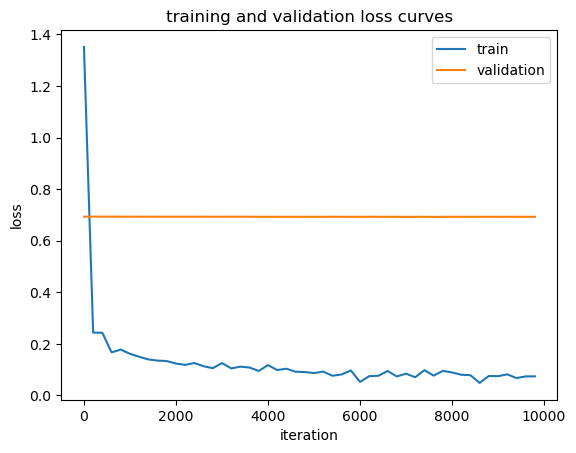

In [19]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [20]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: 0.69254, test_recall@20: 0.01117, test_precision@20: 0.00389, test_ndcg@20: 0.00992


# Make New Recommendatios for a Given User

In [21]:
model.eval()
df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [22]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

In [23]:
USER_ID = 6
NUM_RECS = 4

make_predictions(USER_ID, NUM_RECS)

Here are some movies that user 6 rated highly
title: Mary Reilly (1996), genres: Drama|Horror|Thriller 
title: Walk in the Clouds, A (1995), genres: Drama|Romance 
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
title: Angus (1995), genres: Comedy 

Here are some suggested movies for user 6
title: My Wife is an Actress (Ma Femme est une Actrice) (2001), genres: Comedy|Drama|Romance 
title: Freddy's Dead: The Final Nightmare (Nightmare on Elm Street Part 6: Freddy's Dead, A) (1991), genres: Horror 
title: Buffalo '66 (a.k.a. Buffalo 66) (1998), genres: Drama|Romance 
title: Black Robe (1991), genres: Adventure|Drama 


# Practice: Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}


In [30]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim, n_layers, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.n_layers = embedding_dim, n_layers
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

    def forward(self, edge_index: SparseTensor):
        users_emb_final, items_emb_final = None, None
        ############################################################################
        # TODO: Your code here!
        # you can reference the previous NGCF implementation!
        # Steps: 
        # 1. normalize edge weight 
        # 2. save embedding of each propagation
        # 3. for simplicity, we take the average of embedding among different layers as the output

        # Initial embeddings of users and items
        x_user = self.users_emb.weight
        x_item = self.items_emb.weight

        # Concatenate user and item embeddings for message passing
        x = torch.cat([x_user, x_item], dim=0)

        # Store the embeddings at each layer (including the initial one)
        embs = [x]

        # Propagate through K layers
        for _ in range(self.n_layers):
            # Perform one step of message passing
            x = self.propagate(edge_index, x=x)
            embs.append(x)

        # Average the embeddings from all layers (including the initial embedding)
        embs = torch.stack(embs, dim=0)
        final_embs = torch.mean(embs, dim=0)

        # Split back into user and item embeddings
        users_emb_final, items_emb_final = final_embs[:self.num_users], final_embs[self.num_users:]

        ############################################################################
        return users_emb_final, items_emb_final

    def message(self, x_j: Tensor) -> Tensor:
        ############################################################################
        # TODO: Your code here!
        # define the message function here
        
        ############################################################################
        return x_j

In [33]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
ITERS_PER_EVAL = 100
ITERS_PER_LR_DECAY = 200
K = 20

############################
# TODO: Your code here!
# chose the best hyperparameters!

# hyperparameters
N_LAYERS = 3
LAMBDA = 1e-4
DIM = 64
LR = 1e-3
############################

In [34]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model = LightGCN(num_users, num_movies,embedding_dim=DIM,n_layers=N_LAYERS)
model = model.to(device)
model.train()

# initialize parameters
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=LAMBDA)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


## Training!
Let's see if your LightGCN outperforms NGCF!

In [35]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, items_emb_final = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final = users_emb_final[user_indices]
    pos_items_emb_final = items_emb_final[pos_item_indices]
    neg_items_emb_final = items_emb_final[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, pos_items_emb_final,neg_items_emb_final)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_recall@{K}: {recall:.4f}, val_precision@{K}: {precision:.4f}, val_ndcg@{K}: {ndcg:.4f}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: 0.7032, val_loss: 0.6931, val_recall@20: 0.0041, val_precision@20: 0.0007, val_ndcg@20: 0.0016
[Iteration 100/10000] train_loss: 0.3042, val_loss: 0.6931, val_recall@20: 0.0307, val_precision@20: 0.0098, val_ndcg@20: 0.0227
[Iteration 200/10000] train_loss: 0.2925, val_loss: 0.6934, val_recall@20: 0.0544, val_precision@20: 0.0165, val_ndcg@20: 0.0405
[Iteration 300/10000] train_loss: 0.2475, val_loss: 0.6946, val_recall@20: 0.0441, val_precision@20: 0.0156, val_ndcg@20: 0.0321
[Iteration 400/10000] train_loss: 0.2499, val_loss: 0.6945, val_recall@20: 0.0434, val_precision@20: 0.0149, val_ndcg@20: 0.0336
[Iteration 500/10000] train_loss: 0.2159, val_loss: 0.6949, val_recall@20: 0.0373, val_precision@20: 0.0138, val_ndcg@20: 0.0308
[Iteration 600/10000] train_loss: 0.2099, val_loss: 0.6957, val_recall@20: 0.0398, val_precision@20: 0.0137, val_ndcg@20: 0.0307
[Iteration 700/10000] train_loss: 0.2134, val_loss: 0.6963, val_recall@20: 0.0306, val_precision@20

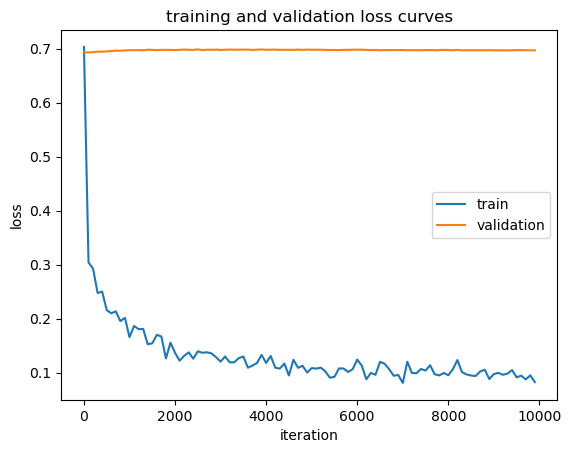

In [36]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [37]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: 0.69592, test_recall@20: 0.02182, test_precision@20: 0.00688, test_ndcg@20: 0.01513
